<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/Notebooks/OC_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [232]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, accuracy_score, recall_score

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

## Reading the dataset from Google Drive


In [233]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')

tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", delimiter="\t",)

labels      = te_data[:, 0]                             # labels
print("Labels:", np.unique(labels))

Dataset: ItalyPowerDemand
Labels: [1. 2.]


## Splitting in Train-Test data

In [234]:
class_label = int(input('Positive class label: '))

train_data  = tr_data[tr_data[:, 0] == class_label, 1:] # train
test_data   = te_data[:, 1:]                            # test

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Positive class label: 1
Train data shape: (34, 24)
Test data shape: (1029, 24)


## Labeling for OCC Task
<li> Label 1 for positive class </li>
<li> Label -1 for other class(es) </li>

In [235]:
occ_labels = [1 if x == class_label else -1 for x in labels]
print("Positive samples:", occ_labels.count(1))
print("Negative samples:", occ_labels.count(-1))

Positive samples: 513
Negative samples: 516


In [236]:
"""pca = PCA(svd_solver='full')

train_data = pca.fit_transform(train_data)
test_data = pca.transform(test_data)
print(train_data.shape)"""

"pca = PCA(svd_solver='full')\n\ntrain_data = pca.fit_transform(train_data)\ntest_data = pca.transform(test_data)\nprint(train_data.shape)"

# MDS Plot 

In [237]:
embedding = MDS(n_components=2)
mds_data = embedding.fit_transform(train_data)
mds_test = embedding.fit_transform(test_data)
print(mds_data.shape)
print(mds_test.shape)

(34, 2)
(1029, 2)


## Train

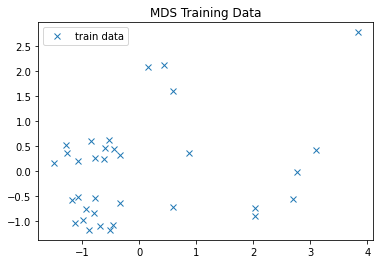

In [238]:
x = [row[0] for row in mds_data]
y = [row[1] for row in mds_data]

plt.plot(x, y, 'x',label='train data')
plt.title('MDS Training Data')
plt.legend()
plt.show()

## Test

In [239]:
negative_mds_test = np.array([x for x in mds_test[np.where(labels!=class_label)]])
positive_mds_test = np.array([x for x in mds_test[np.where(labels==class_label)]])

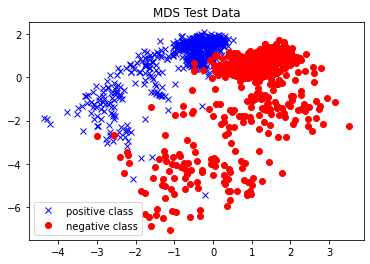

In [240]:
x_positive = [row[0] for row in positive_mds_test]
y_positive = [row[1] for row in positive_mds_test]

x_negative = [row[0] for row in negative_mds_test]
y_negative = [row[1] for row in negative_mds_test]

plt.plot(x_positive, y_positive, 'x', label='positive class', c = 'blue')
plt.plot(x_negative, y_negative, 'o', label='negative class', c = 'red')
plt.title('MDS Test Data')
plt.legend()
plt.show()

# OC-SVM Fitting 

In [241]:
clf = OneClassSVM(gamma='scale', nu=0.15, kernel='rbf').fit(train_data)

# Testing and Evaluating Results

In [242]:
result_labels = clf.predict(test_data)

acc = accuracy_score(occ_labels, result_labels)
precision = precision_score(occ_labels, result_labels)
recall = recall_score(occ_labels, result_labels)

print("Accuracy: %.2f"  % (acc*100) + "%")
print("Precision: %.2f" % (precision*100) + "%")
print("Recall: %.2f"    % (recall*100) + "%")

Accuracy: 88.63%
Precision: 95.00%
Recall: 81.48%
